# Projet : Movie4You

*Objectifs : Mettre en place un système de recommandation se basant sur le jeu de données "MovieLens 1M" pour déterminer les préférences cinématographiques d’un utilisateur, grâce à nos connaissances de son profil.*

## Systeme de recommandation

Un système de recommandation est un type de logiciel ou d'application qui utilise des techniques de traitement de données et d'apprentissage automatique pour suggérer des éléments ou des contenus pertinents à un utilisateur. Ces éléments peuvent inclure des produits, des services, des articles, des films, de la musique, des amis, des informations, etc., en fonction des besoins, des préférences et du comportement de l'utilisateur. Le but principal d'un système de recommandation est d'offrir une expérience personnalisée à l'utilisateur, en lui proposant des choix qui correspondent à ses goûts, ses intérêts, ses habitudes et ses besoins.

L'une des approches les plus simples et néanmoins efficaces pour la recommandation de films en fonction des informations des utilisateurs est le filtrage collaboratif. Le filtrage collaboratif se divise en deux catégories principales :
* Filtrage collaboratif utilisateur-utilisateur : Cette approche recommande des films à un utilisateur en se basant sur les goûts et les préférences d'autres utilisateurs similaires. La similarité entre les utilisateurs peut être calculée en utilisant des mesures telles que la similarité cosinus.
* Filtrage collaboratif article-article : Au lieu de se baser sur la similarité entre les utilisateurs, cette approche recommande des films en se basant sur la similarité entre les films eux-mêmes. Si un utilisateur a aimé un certain film, d'autres films similaires peuvent lui être recommandés.

## Architecture à mettre en place

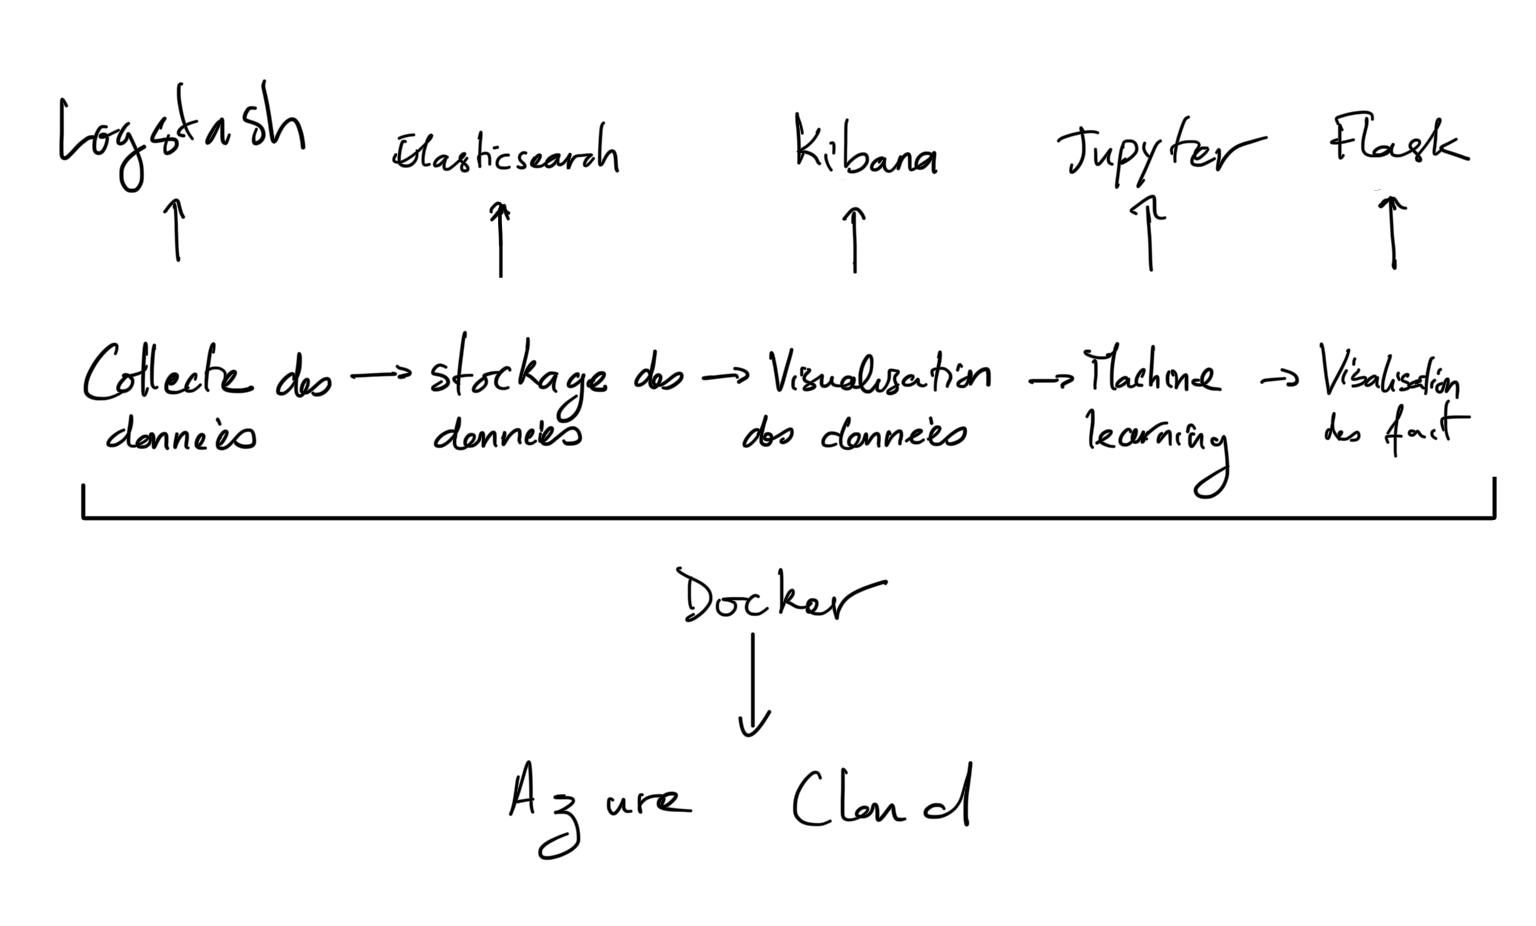

## Librairie

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
current_time = datetime.datetime.now()

%matplotlib inline

# machine learning
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

## Exploration des données

Les informations sur le film se trouvent dans le fichier "movies.dat" et se trouvent ci-dessous
format:

MovieID::Title::Genres

- Les titres sont identiques aux titres fournis par l'IMDB (y compris année de sortie);
- Les genres sont séparés par des barres et sont sélectionnés parmi les genres suivants :
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western
- Certains MovieID ne correspondent pas à un film en raison d'une duplication accidentelle inscriptions et/ou inscriptions aux tests;
- Les films sont pour la plupart saisis à la main, des erreurs et des incohérences peuvent donc exister;

In [2]:
#Import Movies Dataset
dfMovies = pd.read_csv("./data/movies.dat",sep="::",names=["MovieID","Title","Genres"],engine='python' , encoding='latin-1')
# Exemple de donnée enregistré
dfMovies.head(20)

MovieID                                  Title  \
0         1                       Toy Story (1995)   
1         2                         Jumanji (1995)   
2         3                Grumpier Old Men (1995)   
3         4               Waiting to Exhale (1995)   
4         5     Father of the Bride Part II (1995)   
5         6                            Heat (1995)   
6         7                         Sabrina (1995)   
7         8                    Tom and Huck (1995)   
8         9                    Sudden Death (1995)   
9        10                       GoldenEye (1995)   
10       11         American President, The (1995)   
11       12     Dracula: Dead and Loving It (1995)   
12       13                           Balto (1995)   
13       14                           Nixon (1995)   
14       15                Cutthroat Island (1995)   
15       16                          Casino (1995)   
16       17           Sense and Sensibility (1995)   
17       18                      Four Rooms (1995)   
18       19  Ace Ventura: When Nature Calls (1995)   
19       20                     Money Train (1995)   

                          Genres  
0    Animation|Children's|Comedy  
1   Adventure|Children's|Fantasy  
2                 Comedy|Romance  
3                   Comedy|Drama  
4                         Comedy  
5          Action|Crime|Thriller  
6                 Comedy|Romance  
7           Adventure|Children's  
8                         Action  
9      Action|Adventure|Thriller  
10          Comedy|Drama|Romance  
11                 Comedy|Horror  
12          Animation|Children's  
13                         Drama  
14      Action|Adventure|Romance  
15                Drama|Thriller  
16                 Drama|Romance  
17                      Thriller  
18                        Comedy  
19                        Action

Toutes les notes sont contenues dans le fichier "ratings.dat" et se trouvent dans le
format suivant :

UserID::MovieID::Rating::Timestamp

- Les ID utilisateur vont de 1 à 6040
- Les MovieID vont de 1 à 3952
- Les notes sont établies sur une échelle de 5 étoiles (notes entières uniquement)
- L'horodatage est représenté en secondes depuis l'époque renvoyée par time(2)
- Chaque utilisateur a au moins 20 notes

In [3]:
#Import Ratings Dataset
dfRatings = pd.read_csv("./data/ratings.dat",sep="::",names=["UserID","MovieID","Rating","Timestamp"],engine='python' , encoding='latin-1')
# Exemple de donnée enregistré
dfRatings.head(20)

UserID  MovieID  Rating  Timestamp
0        1     1193       5  978300760
1        1      661       3  978302109
2        1      914       3  978301968
3        1     3408       4  978300275
4        1     2355       5  978824291
5        1     1197       3  978302268
6        1     1287       5  978302039
7        1     2804       5  978300719
8        1      594       4  978302268
9        1      919       4  978301368
10       1      595       5  978824268
11       1      938       4  978301752
12       1     2398       4  978302281
13       1     2918       4  978302124
14       1     1035       5  978301753
15       1     2791       4  978302188
16       1     2687       3  978824268
17       1     2018       4  978301777
18       1     3105       5  978301713
19       1     2797       4  978302039

Les informations utilisateur se trouvent dans le fichier "users.dat" et se trouvent ci-dessous
format:

UserID::Gender::Age::Occupation::Zip-code

Toutes les informations démographiques sont fournies volontairement par les utilisateurs et sont pas vérifié pour l'exactitude. Seuls les utilisateurs ayant fourni des données démographiques sont incluses dans cet ensemble de données.

- Le sexe est indiqué par un « M » pour homme et un « F » pour femme.
- L'âge est choisi parmi les fourchettes suivantes :
    * 1 : « Moins de 18 ans »
    * 18 : « 18-24 »
    * 25 : "25-34"
    * 35 : "35-44"
    * 45 : "45-49"
    * 50 : "50-55"
    * 56 : "56+"
- La profession est choisie parmi les choix suivants :
    * 0 : « autre » ou non précisé
    * 1 : « universitaire/éducateur »
    * 2 : « artiste »
    * 3 : « employé de bureau/administrateur »
    * 4 : « étudiant/étudiant diplômé »
    * 5 : « service client»
    * 6 : « médecin/soignant »
    * 7 : « cadre/manager »
    * 8 : « agriculteur »
    * 9 : « femme au foyer »
    * 10 : « Élève de la maternelle à la 12e année »
    * 11 : « avocat »
    * 12 : « programmeur »
    * 13 : « retraité »
    * 14 : « ventes/marketing »
    * 15 : « scientifique »
    * 16 : « indépendant »
    * 17 : « technicien/ingénieur »
    * 18 : « commerçant/artisan »
    * 19 : « chômeurs »
    * 20 : « écrivain »
- Code postal pour l'emplacement de l'utilisateur.

In [4]:
#Import Users Dataset
dfUsers = pd.read_csv("./data/users.dat",sep="::",names=["UserID","Gender","Age","Occupation","Zip-code"],engine='python' , encoding='latin-1')
# Exemple de donnée enregistré
dfUsers.head(20)

UserID Gender  Age  Occupation Zip-code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25          20    55455
5        6      F   50           9    55117
6        7      M   35           1    06810
7        8      M   25          12    11413
8        9      M   25          17    61614
9       10      F   35           1    95370
10      11      F   25           1    04093
11      12      M   25          12    32793
12      13      M   45           1    93304
13      14      M   35           0    60126
14      15      M   25           7    22903
15      16      F   35           0    20670
16      17      M   50           1    95350
17      18      F   18           3    95825
18      19      M    1          10    48073
19      20      M   25          14    55113

## Distributions des données

### Distribution sur les âges

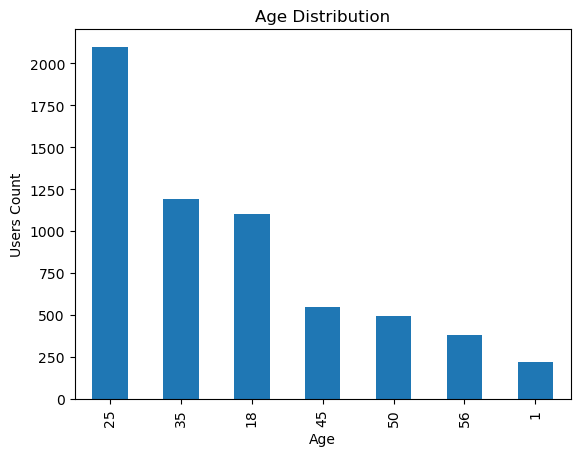

In [5]:
dfUsers['Age'].value_counts().plot(kind='bar')
plt.xlabel("Age")
plt.title("Age Distribution")
plt.ylabel('Users Count')
plt.show()

### Distribution sur le genre

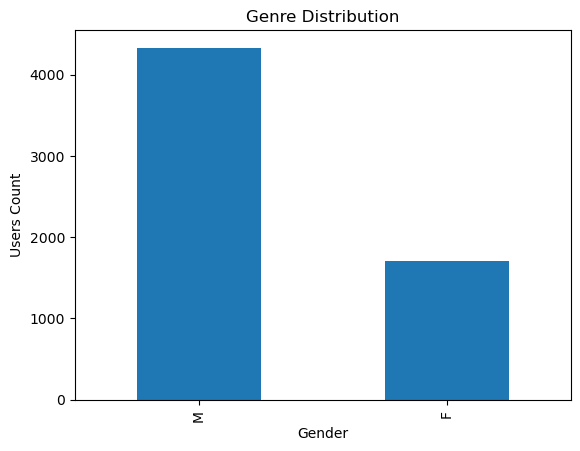

In [6]:
dfUsers['Gender'].value_counts().plot(kind='bar')
plt.xlabel("Gender")
plt.title("Genre Distribution")
plt.ylabel('Users Count')
plt.show()

### Distribution sur les occupations

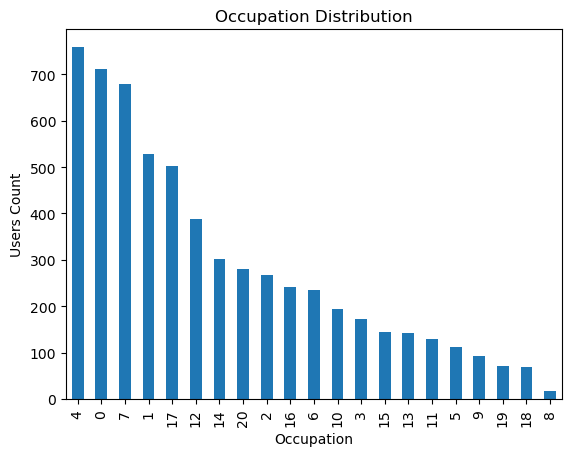

In [7]:
dfUsers['Occupation'].value_counts().plot(kind='bar')
plt.xlabel("Occupation")
plt.title("Occupation Distribution")
plt.ylabel('Users Count')
plt.show()

## Classement

Pour la suite nous allons faire une jointure des trois tables

In [8]:
dfMovieRatings = dfMovies.merge(dfRatings,on='MovieID',how='inner')
dfMaster = dfMovieRatings.merge(dfUsers,on="UserID",how='inner')
dfMaster.head()

MovieID                                      Title  \
0        1                           Toy Story (1995)   
1       48                          Pocahontas (1995)   
2      150                           Apollo 13 (1995)   
3      260  Star Wars: Episode IV - A New Hope (1977)   
4      527                    Schindler's List (1993)   

                                 Genres  UserID  Rating  Timestamp Gender  \
0           Animation|Children's|Comedy       1       5  978824268      F   
1  Animation|Children's|Musical|Romance       1       5  978824351      F   
2                                 Drama       1       5  978301777      F   
3       Action|Adventure|Fantasy|Sci-Fi       1       4  978300760      F   
4                             Drama|War       1       5  978824195      F   

   Age  Occupation Zip-code  
0    1          10    48067  
1    1          10    48067  
2    1          10    48067  
3    1          10    48067  
4    1          10    48067

### Classement par note pour un film

In [9]:
toystoryRating = dfMaster[dfMaster['Title'].str.contains('Toy Story') == True]
toystoryRating.sort_values(by=['Rating'], ascending=False)

MovieID               Title                       Genres  UserID  \
0             1    Toy Story (1995)  Animation|Children's|Comedy       1   
355033        1    Toy Story (1995)  Animation|Children's|Comedy    3709   
359932        1    Toy Story (1995)  Animation|Children's|Comedy    3751   
359775        1    Toy Story (1995)  Animation|Children's|Comedy    3749   
359229        1    Toy Story (1995)  Animation|Children's|Comedy    3738   
...         ...                 ...                          ...     ...   
980130     3114  Toy Story 2 (1999)  Animation|Children's|Comedy    4703   
449972     3114  Toy Story 2 (1999)  Animation|Children's|Comedy    4626   
369550     3114  Toy Story 2 (1999)  Animation|Children's|Comedy    3822   
868426     3114  Toy Story 2 (1999)  Animation|Children's|Comedy    2043   
472674        1    Toy Story (1995)  Animation|Children's|Comedy    4905   

        Rating  Timestamp Gender  Age  Occupation    Zip-code  
0            5  978824268      F    1          10       48067  
355033       5  966275789      M   25          12       89502  
359932       5  966128204      F   35          12       55555  
359775       5  966133515      F   25           0       60664  
359229       5  966209247      M   45           7  01904-1355  
...        ...        ...    ...  ...         ...         ...  
980130       1  963541230      M   25           7       02035  
449972       1  964114390      M   25          14       97219  
369550       1  971466624      M   45          20       98027  
868426       1  974666636      M   25          14       37931  
472674       1  962681831      F   45           1       60417  

[3662 rows x 10 columns]

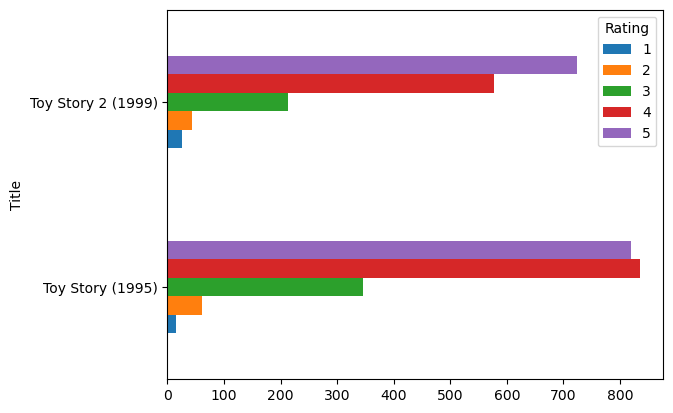

In [10]:
toystoryRating.groupby(["Title","Rating"]).size().unstack().plot(kind='barh',stacked=False,legend=True)
plt.show()

### Classement pour tous les films (Top 15)

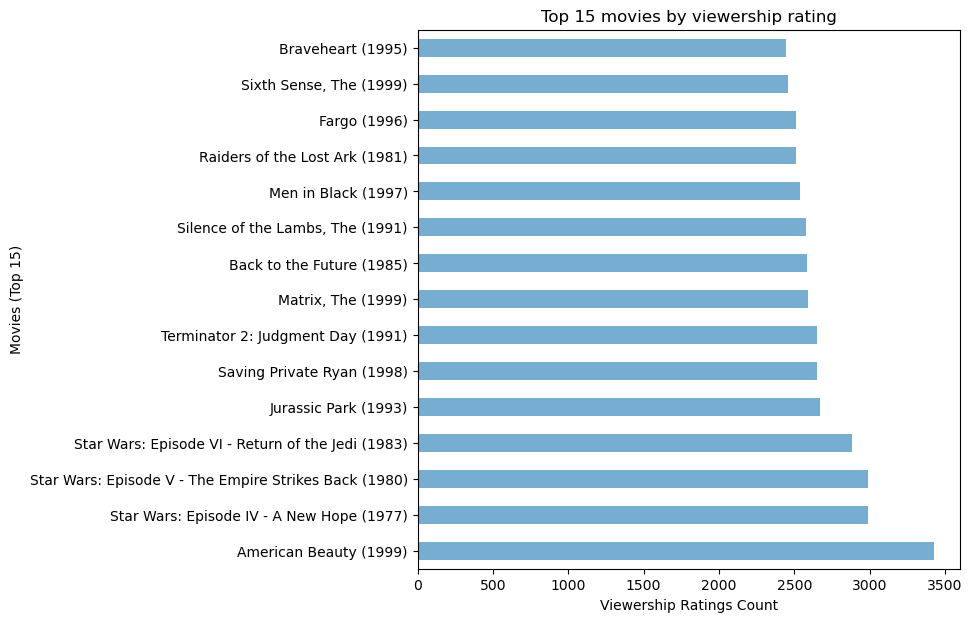

In [11]:
dfTop15 = dfMaster.groupby('Title').size().sort_values(ascending=False)[:15]
dfTop15.plot(kind='barh',alpha=0.6,figsize=(7,7))
plt.xlabel("Viewership Ratings Count")
plt.ylabel("Movies (Top 15)")
plt.title("Top 15 movies by viewership rating")
plt.show()

### Classement pour un utilisateur

In [12]:
userId = 2696
userRatingById = dfMaster[dfMaster["UserID"] == userId]
userRatingById.sort_values(by=['Rating'], ascending=False)

MovieID                                           Title  \
991036      800                                Lone Star (1996)   
991045     1645                    Devil's Advocate, The (1997)   
991047     1783                                 Palmetto (1998)   
991037     1092                           Basic Instinct (1992)   
991053     3176                 Talented Mr. Ripley, The (1999)   
991039     1258                             Shining, The (1980)   
991051     2389                                   Psycho (1998)   
991049     1892                        Perfect Murder, A (1998)   
991042     1617                        L.A. Confidential (1997)   
991043     1625                                Game, The (1997)   
991048     1805                              Wild Things (1998)   
991046     1711  Midnight in the Garden of Good and Evil (1997)   
991035      350                              Client, The (1994)   
991041     1589                                 Cop Land (1997)   
991038     1097               E.T. the Extra-Terrestrial (1982)   
991044     1644          I Know What You Did Last Summer (1997)   
991050     2338    I Still Know What You Did Last Summer (1998)   
991040     1270                       Back to the Future (1985)   
991052     2713                              Lake Placid (1999)   
991054     3386                                      JFK (1991)   

                                  Genres  UserID  Rating  Timestamp Gender  \
991036                     Drama|Mystery    2696       5  973308842      M   
991045     Crime|Horror|Mystery|Thriller    2696       4  973308904      M   
991047        Film-Noir|Mystery|Thriller    2696       4  973308865      M   
991037                  Mystery|Thriller    2696       4  973308886      M   
991053            Drama|Mystery|Thriller    2696       4  973308865      M   
991039                            Horror    2696       4  973308710      M   
991051             Crime|Horror|Thriller    2696       4  973308710      M   
991049                  Mystery|Thriller    2696       4  973308904      M   
991042  Crime|Film-Noir|Mystery|Thriller    2696       4  973308842      M   
991043                  Mystery|Thriller    2696       4  973308842      M   
991048      Crime|Drama|Mystery|Thriller    2696       4  973308886      M   
991046        Comedy|Crime|Drama|Mystery    2696       4  973308904      M   
991035            Drama|Mystery|Thriller    2696       3  973308886      M   
991041               Crime|Drama|Mystery    2696       3  973308865      M   
991038   Children's|Drama|Fantasy|Sci-Fi    2696       3  973308690      M   
991044           Horror|Mystery|Thriller    2696       2  973308920      M   
991050           Horror|Mystery|Thriller    2696       2  973308920      M   
991040                     Comedy|Sci-Fi    2696       2  973308676      M   
991052                   Horror|Thriller    2696       1  973308710      M   
991054                     Drama|Mystery    2696       1  973308842      M   

        Age  Occupation Zip-code  
991036   25           7    24210  
991045   25           7    24210  
991047   25           7    24210  
991037   25           7    24210  
991053   25           7    24210  
991039   25           7    24210  
991051   25           7    24210  
991049   25           7    24210  
991042   25           7    24210  
991043   25           7    24210  
991048   25           7    24210  
991046   25           7    24210  
991035   25           7    24210  
991041   25           7    24210  
991038   25           7    24210  
991044   25           7    24210  
991050   25           7    24210  
991040   25           7    24210  
991052   25           7    24210  
991054   25           7    24210

## Classement sur les occupations

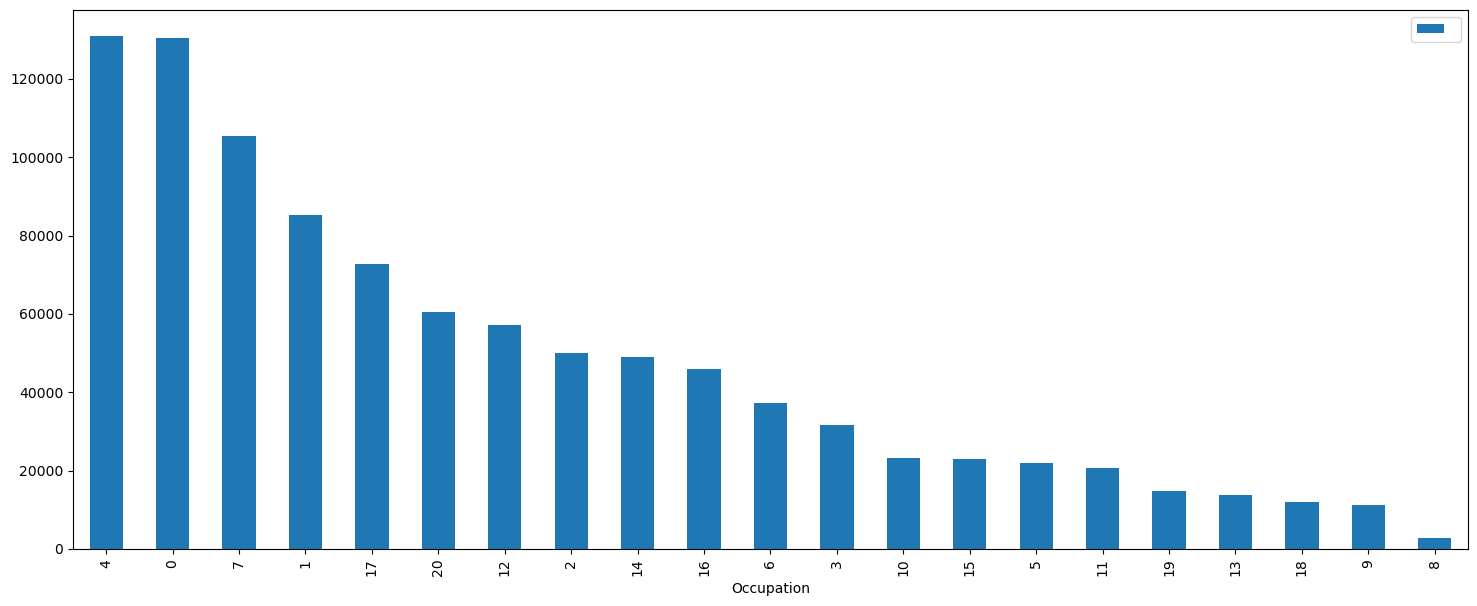

In [13]:
dfMaster.groupby(["Occupation"]).size().sort_values(ascending=False).plot(kind='bar',figsize=(18,7),stacked=False,legend=True)
plt.show()

- Profession :
    * 0 : « autre » ou non précisé
    * 1 : « universitaire/éducateur »
    * 2 : « artiste »
    * 3 : « employé de bureau/administrateur »
    * 4 : « étudiant/étudiant diplômé »
    * 5 : « service client»
    * 6 : « médecin/soignant »
    * 7 : « cadre/manager »
    * 8 : « agriculteur »
    * 9 : « femme au foyer »
    * 10 : « Élève de la maternelle à la 12e année »
    * 11 : « avocat »
    * 12 : « programmeur »
    * 13 : « retraité »
    * 14 : « ventes/marketing »
    * 15 : « scientifique »
    * 16 : « indépendant »
    * 17 : « technicien/ingénieur »
    * 18 : « commerçant/artisan »
    * 19 : « chômeurs »
    * 20 : « écrivain »

# Néttoyage des données

## Néttoyage année de sortie

In [14]:
dfMaster[["title","Year"]] = dfMaster.Title.str.extract("(.)\s\((.\d+)",expand=True)
dfMaster = dfMaster.drop(columns=["title"])
dfMaster['Year'] = dfMaster.Year.astype(int)
dfMaster['Movie_Age'] = 2000 - dfMaster.Year
dfMaster.head()

MovieID                                      Title  \
0        1                           Toy Story (1995)   
1       48                          Pocahontas (1995)   
2      150                           Apollo 13 (1995)   
3      260  Star Wars: Episode IV - A New Hope (1977)   
4      527                    Schindler's List (1993)   

                                 Genres  UserID  Rating  Timestamp Gender  \
0           Animation|Children's|Comedy       1       5  978824268      F   
1  Animation|Children's|Musical|Romance       1       5  978824351      F   
2                                 Drama       1       5  978301777      F   
3       Action|Adventure|Fantasy|Sci-Fi       1       4  978300760      F   
4                             Drama|War       1       5  978824195      F   

   Age  Occupation Zip-code  Year  Movie_Age  
0    1          10    48067  1995          5  
1    1          10    48067  1995          5  
2    1          10    48067  1995          5  
3    1          10    48067  1977         23  
4    1          10    48067  1993          7

## Néttoyage sur le genre utilisateur

In [15]:
dfMaster['Gender'] = dfMaster.Gender.replace('F','1')
dfMaster['Gender'] = dfMaster.Gender.replace('M','0')
dfMaster['Gender'] = dfMaster.Gender.astype(int)
dfMaster.head()

MovieID                                      Title  \
0        1                           Toy Story (1995)   
1       48                          Pocahontas (1995)   
2      150                           Apollo 13 (1995)   
3      260  Star Wars: Episode IV - A New Hope (1977)   
4      527                    Schindler's List (1993)   

                                 Genres  UserID  Rating  Timestamp  Gender  \
0           Animation|Children's|Comedy       1       5  978824268       1   
1  Animation|Children's|Musical|Romance       1       5  978824351       1   
2                                 Drama       1       5  978301777       1   
3       Action|Adventure|Fantasy|Sci-Fi       1       4  978300760       1   
4                             Drama|War       1       5  978824195       1   

   Age  Occupation Zip-code  Year  Movie_Age  
0    1          10    48067  1995          5  
1    1          10    48067  1995          5  
2    1          10    48067  1995          5  
3    1          10    48067  1977         23  
4    1          10    48067  1993          7

## Néttoyage des noms de colonne

In [16]:
col = []
for i in dfMaster.columns:
    i = i.replace('-','_')
    i = i.replace('(','_')
    i = i.replace(')','_')
    i = i.replace("'",'_')
    col.append(i)
dfMaster.columns = col
dfMaster.head()

MovieID                                      Title  \
0        1                           Toy Story (1995)   
1       48                          Pocahontas (1995)   
2      150                           Apollo 13 (1995)   
3      260  Star Wars: Episode IV - A New Hope (1977)   
4      527                    Schindler's List (1993)   

                                 Genres  UserID  Rating  Timestamp  Gender  \
0           Animation|Children's|Comedy       1       5  978824268       1   
1  Animation|Children's|Musical|Romance       1       5  978824351       1   
2                                 Drama       1       5  978301777       1   
3       Action|Adventure|Fantasy|Sci-Fi       1       4  978300760       1   
4                             Drama|War       1       5  978824195       1   

   Age  Occupation Zip_code  Year  Movie_Age  
0    1          10    48067  1995          5  
1    1          10    48067  1995          5  
2    1          10    48067  1995          5  
3    1          10    48067  1977         23  
4    1          10    48067  1993          7

# Prédiction pour la suggestion de films

## Construction du modèle

In [52]:
import json
# Fonction pour recommender en fonction d'un utilisateur qui déjà des notes
def get_movie_recommendations(user_id, num_recommendations):
    
    # sélection les films les mieux notés
    dfMaster_best = dfMaster[dfMaster["Rating"] >= 3].sort_values(by=['Rating','Year'], ascending=False)
    
    # Contruction du modèle
    train_data, test_data = train_test_split(dfMaster_best, test_size=0.2)
    user_movie_matrix = train_data.pivot_table(index='UserID', columns='MovieID', values='Rating')
    user_movie_matrix = user_movie_matrix.fillna(0)
    user_similarity = cosine_similarity(user_movie_matrix)
    
    # vérification
    if user_id not in user_movie_matrix.index:
        print("L'utilisateur {} n'existe pas dans les données.".format(user_id))
        return "[]"

    # Sélectionnez les films préférés de l'utilisateur
    user_ratings = user_movie_matrix.loc[user_id]

    # Créez une liste de films déjà notés par l'utilisateur
    rated_movies = user_ratings[user_ratings > 0].index

    # Créez une liste pour stocker les recommandations
    recommendations = []

    for movie_id in user_movie_matrix.columns:
        # Si l'utilisateur a déjà noté ce film, passez à l'itération suivante
        if movie_id in rated_movies:
            continue

        # Calculez la similarité entre l'utilisateur donné et les autres utilisateurs qui ont noté ce film
        similarity = user_movie_matrix[user_movie_matrix[movie_id] > 0].dot(user_ratings)

        # Triez les utilisateurs similaires par ordre décroissant de similarité
        sorted_users = similarity.sort_values(ascending=False)

        # Sélectionnez le premier utilisateur (le plus similaire) et ajoutez le film à la liste des recommandations
        if not sorted_users.empty:
            most_similar_user = sorted_users.index[0]
            recommendations.append({"MovieID": movie_id, "Similarity": sorted_users[most_similar_user]})

        # Si nous avons atteint le nombre souhaité de recommandations, sortez de la boucle
        if len(recommendations) >= num_recommendations:
            break

    # Triez les recommandations par score de similarité décroissant
    recommendations = sorted(recommendations, key=lambda x: x["Similarity"], reverse=True)

    return recommendations

In [53]:
def get_movie_info(movie_id):
    return dfMovies.iat[movie_id, 1] + ", Genre : " + dfMovies.iat[movie_id, 2]
    
def print_recommendation():
    # Utilisez la fonction pour obtenir les 10 meilleurs films recommandés pour un utilisateur spécifique
    top_movie_recommendations = get_movie_recommendations(1, num_recommendations=10)
    print("Top 10 films recommandés pour l'utilisateur 1 :")
    for i, recommendation in enumerate(top_movie_recommendations):
        print(f"{i+1}. ID: {recommendation['MovieID']}, Title: {get_movie_info(recommendation['MovieID'])}, Similarity: {recommendation['Similarity']}")

print_recommendation()

Top 10 films recommandés pour l'utilisateur 1 :
1. ID: 2, Title: Grumpier Old Men (1995), Genre : Comedy|Romance, Similarity: 588.0
2. ID: 5, Title: Heat (1995), Genre : Action|Crime|Thriller, Similarity: 588.0
3. ID: 7, Title: Tom and Huck (1995), Genre : Adventure|Children's, Similarity: 588.0
4. ID: 11, Title: Dracula: Dead and Loving It (1995), Genre : Comedy|Horror, Similarity: 588.0
5. ID: 4, Title: Father of the Bride Part II (1995), Genre : Comedy, Similarity: 573.0
6. ID: 6, Title: Sabrina (1995), Genre : Comedy|Romance, Similarity: 550.0
7. ID: 10, Title: American President, The (1995), Genre : Comedy|Drama|Romance, Similarity: 550.0
8. ID: 8, Title: Sudden Death (1995), Genre : Action, Similarity: 520.0
9. ID: 3, Title: Waiting to Exhale (1995), Genre : Comedy|Drama, Similarity: 490.0
10. ID: 9, Title: GoldenEye (1995), Genre : Action|Adventure|Thriller, Similarity: 402.0


In [75]:
# Fausse données d'un nouvel utilisateur
fake_Age = 18
fake_Occupation = 4
fake_Gender = 0

In [76]:
import json
# Fonction pour recommender en fonction d'un nouvel utilisateur où qui n'a pas de note
def get_movie_recommendations_Age(age, num_recommendations):
    
    # sélection les films les mieux notés
    dfMaster_best = dfMaster[dfMaster["Rating"] >= 3].sort_values(by=['Rating','Year'], ascending=False)
    
    # Contruction du modèle
    train_data, test_data = train_test_split(dfMaster_best, test_size=0.2)
    user_movie_matrix = train_data.pivot_table(index='Age', columns='MovieID', values='Rating')
    user_movie_matrix = user_movie_matrix.fillna(0)
    user_similarity = cosine_similarity(user_movie_matrix)
    
    # vérification
    if age not in user_movie_matrix.index:
        print("L'âge utilisateur {} n'existe pas dans les données.".format(age))
        return "[]"

    # Sélectionnez les films préférés des utilisateurs
    user_ratings = user_movie_matrix.loc[age]

    # Créez une liste de films déjà notés par les utilisateurs
    rated_movies = user_ratings[user_ratings > 0].index

    # Créez une liste pour stocker les recommandations
    recommendations = []

    for movie_id in user_movie_matrix.columns:
        # Si l'utilisateur a déjà noté ce film, passez à l'itération suivante
        if movie_id in rated_movies:
            continue

        # Calculez la similarité entre l'utilisateur donné et les autres utilisateurs qui ont noté ce film
        similarity = user_movie_matrix[user_movie_matrix[movie_id] > 0].dot(user_ratings)

        # Triez les utilisateurs similaires par ordre décroissant de similarité
        sorted_users = similarity.sort_values(ascending=False)

        # Sélectionnez le premier utilisateur (le plus similaire) et ajoutez le film à la liste des recommandations
        if not sorted_users.empty:
            most_similar_user = sorted_users.index[0]
            recommendations.append({"MovieID": movie_id, "Similarity": sorted_users[most_similar_user]})

        # Si nous avons atteint le nombre souhaité de recommandations, sortez de la boucle
        if len(recommendations) >= num_recommendations:
            break

    # Triez les recommandations par score de similarité décroissant
    recommendations = sorted(recommendations, key=lambda x: x["Similarity"], reverse=True)

    return recommendations

In [69]:
def get_movie_info(movie_id):
    return dfMovies.iat[movie_id, 1] + ", Genre : " + dfMovies.iat[movie_id, 2]
    
def print_recommendation():
    # Utilisez la fonction pour obtenir les 10 meilleurs films recommandés pour une catégorie d'utilisateur
    top_movie_recommendations_Age = get_movie_recommendations_Age(fake_Age, num_recommendations=10)
    print("Top 10 films recommandés pour l'utilisateur de la tranche d'âge " + str(fake_Age) + " :")
    for i, recommendation in enumerate(top_movie_recommendations_Age):
        print(f"{i+1}. ID: {recommendation['MovieID']}, Title: {get_movie_info(recommendation['MovieID'])}, Similarity: {recommendation['Similarity']}")

print_recommendation()

Top 10 films recommandés pour l'utilisateur de la tranche d'âge 18 :
1. ID: 108, Title: Braveheart (1995), Genre : Action|Drama|War, Similarity: 43987.0961382749
2. ID: 55, Title: Kids of the Round Table (1995), Genre : Adventure|Children's|Fantasy, Similarity: 43987.09613827487
3. ID: 84, Title: Angels and Insects (1995), Genre : Drama|Romance, Similarity: 43987.09613827487
4. ID: 53, Title: Big Green, The (1995), Genre : Children's|Comedy, Similarity: 43987.096138274865
5. ID: 67, Title: French Twist (Gazon maudit) (1995), Genre : Comedy|Romance, Similarity: 43987.096138274865
6. ID: 75, Title: Screamers (1995), Genre : Sci-Fi|Thriller, Similarity: 43987.096138274865
7. ID: 33, Title: Babe (1995), Genre : Children's|Comedy|Drama, Similarity: 43987.096138274836
8. ID: 98, Title: City Hall (1996), Genre : Drama|Thriller, Similarity: 42935.009817537
9. ID: 90, Title: Mary Reilly (1996), Genre : Drama|Thriller, Similarity: 42935.00981753691
10. ID: 56, Title: Home for the Holidays (1995)

In [77]:
import json
# Fonction pour recommender en fonction l'occupation d'un nouvel utilisateur où qui n'a pas de note
def get_movie_recommendations_Occupation(occupation, num_recommendations):
    
    # sélection les films les mieux notés
    dfMaster_best = dfMaster[dfMaster["Rating"] >= 3].sort_values(by=['Rating','Year'], ascending=False)
    
    # Contruction du modèle
    train_data, test_data = train_test_split(dfMaster_best, test_size=0.2)
    user_movie_matrix = train_data.pivot_table(index='Occupation', columns='MovieID', values='Rating')
    user_movie_matrix = user_movie_matrix.fillna(0)
    user_similarity = cosine_similarity(user_movie_matrix)
    
    # vérification
    if occupation not in user_movie_matrix.index:
        print("L'occupation utilisateur {} n'existe pas dans les données.".format(occupation))
        return "[]"

    # Sélectionnez les films préférés des utilisateur
    user_ratings = user_movie_matrix.loc[occupation]

    # Créez une liste de films déjà notés par les utilisateurs
    rated_movies = user_ratings[user_ratings > 0].index

    # Créez une liste pour stocker les recommandations
    recommendations = []

    for movie_id in user_movie_matrix.columns:
        # Si l'utilisateur a déjà noté ce film, passez à l'itération suivante
        if movie_id in rated_movies:
            continue

        # Calculez la similarité entre l'utilisateur donné et les autres utilisateurs qui ont noté ce film
        similarity = user_movie_matrix[user_movie_matrix[movie_id] > 0].dot(user_ratings)

        # Triez les utilisateurs similaires par ordre décroissant de similarité
        sorted_users = similarity.sort_values(ascending=False)

        # Sélectionnez le premier utilisateur (le plus similaire) et ajoutez le film à la liste des recommandations
        if not sorted_users.empty:
            most_similar_user = sorted_users.index[0]
            recommendations.append({"MovieID": movie_id, "Similarity": sorted_users[most_similar_user]})

        # Si nous avons atteint le nombre souhaité de recommandations, sortez de la boucle
        if len(recommendations) >= num_recommendations:
            break

    # Triez les recommandations par score de similarité décroissant
    recommendations = sorted(recommendations, key=lambda x: x["Similarity"], reverse=True)

    return recommendations

In [71]:
def get_movie_info(movie_id):
    return dfMovies.iat[movie_id, 1] + ", Genre : " + dfMovies.iat[movie_id, 2]
    
def print_recommendation():
    # Utilisez la fonction pour obtenir les 10 meilleurs films recommandés pour une catégorie d'utilisateur
    top_movie_recommendations_Occupation = get_movie_recommendations_Occupation(fake_Occupation, num_recommendations=10)
    print("Top 10 films recommandés pour " + str(fake_Occupation) + " - étudiant/étudiant diplômé :")
    for i, recommendation in enumerate(top_movie_recommendations_Occupation):
        print(f"{i+1}. ID: {recommendation['MovieID']}, Title: {get_movie_info(recommendation['MovieID'])}, Similarity: {recommendation['Similarity']}")

print_recommendation()

Top 10 films recommandés pour 4 - étudiant/étudiant diplômé :
1. ID: 33, Title: Babe (1995), Genre : Children's|Comedy|Drama, Similarity: 43263.833021537626
2. ID: 96, Title: Shopping (1994), Genre : Action|Thriller, Similarity: 43263.83302153758
3. ID: 106, Title: Catwalk (1995), Genre : Documentary, Similarity: 43263.83302153758
4. ID: 75, Title: Screamers (1995), Genre : Sci-Fi|Thriller, Similarity: 43263.833021537575
5. ID: 90, Title: Mary Reilly (1996), Genre : Drama|Thriller, Similarity: 43263.833021537575
6. ID: 114, Title: Anne Frank Remembered (1995), Genre : Documentary, Similarity: 43263.833021537575
7. ID: 67, Title: French Twist (Gazon maudit) (1995), Genre : Comedy|Romance, Similarity: 40919.877425801584
8. ID: 130, Title: Jade (1995), Genre : Thriller, Similarity: 40919.87742580155
9. ID: 108, Title: Braveheart (1995), Genre : Action|Drama|War, Similarity: 40466.14061991437
10. ID: 56, Title: Home for the Holidays (1995), Genre : Drama, Similarity: 38940.67986492287


In [78]:
import json
# Fonction pour recommender en fonction l'occupation d'un nouvel utilisateur où qui n'a pas de note
def get_movie_recommendations_Gender(gender, num_recommendations):
    
    # sélection les films les mieux notés
    dfMaster_best = dfMaster[dfMaster["Rating"] >= 3].sort_values(by=['Rating','Year'], ascending=False)
    
    # Contruction du modèle
    train_data, test_data = train_test_split(dfMaster_best, test_size=0.2)
    user_movie_matrix = train_data.pivot_table(index='Gender', columns='MovieID', values='Rating')
    user_movie_matrix = user_movie_matrix.fillna(0)
    user_similarity = cosine_similarity(user_movie_matrix)
    
    # vérification
    if gender not in user_movie_matrix.index:
        print("Le genre utilisateur {} n'existe pas dans les données.".format(gender))
        return "[]"

    # Sélectionnez les films préférés des utilisateur
    user_ratings = user_movie_matrix.loc[gender]

    # Créez une liste de films déjà notés par les utilisateurs
    rated_movies = user_ratings[user_ratings > 0].index

    # Créez une liste pour stocker les recommandations
    recommendations = []

    for movie_id in user_movie_matrix.columns:
        # Si l'utilisateur a déjà noté ce film, passez à l'itération suivante
        if movie_id in rated_movies:
            continue

        # Calculez la similarité entre l'utilisateur donné et les autres utilisateurs qui ont noté ce film
        similarity = user_movie_matrix[user_movie_matrix[movie_id] > 0].dot(user_ratings)

        # Triez les utilisateurs similaires par ordre décroissant de similarité
        sorted_users = similarity.sort_values(ascending=False)

        # Sélectionnez le premier utilisateur (le plus similaire) et ajoutez le film à la liste des recommandations
        if not sorted_users.empty:
            most_similar_user = sorted_users.index[0]
            recommendations.append({"MovieID": movie_id, "Similarity": sorted_users[most_similar_user]})

        # Si nous avons atteint le nombre souhaité de recommandations, sortez de la boucle
        if len(recommendations) >= num_recommendations:
            break

    # Triez les recommandations par score de similarité décroissant
    recommendations = sorted(recommendations, key=lambda x: x["Similarity"], reverse=True)

    return recommendations

In [81]:
def get_movie_info(movie_id):
    return dfMovies.iat[movie_id, 1] + ", Genre : " + dfMovies.iat[movie_id, 2]
    
def print_recommendation():
    # Utilisez la fonction pour obtenir les 10 meilleurs films recommandés pour une catégorie d'utilisateur
    top_movie_recommendations_Gender = get_movie_recommendations_Gender(fake_Gender, num_recommendations=10)
    print("Top 10 films recommandés pour " + str(fake_Gender) + " - étudiant/étudiante diplômé :")
    for i, recommendation in enumerate(top_movie_recommendations_Gender):
        print(f"{i+1}. ID: {recommendation['MovieID']}, Title: {get_movie_info(recommendation['MovieID'])}, Similarity: {recommendation['Similarity']}")

print_recommendation()

Top 10 films recommandés pour 0 - étudiant/étudiante diplômé :
1. ID: 139, Title: Birdcage, The (1996), Genre : Comedy, Similarity: 47346.01837400082
2. ID: 286, Title: Only You (1994), Genre : Comedy|Romance, Similarity: 47346.01837400082
3. ID: 396, Title: Homage (1995), Genre : Drama, Similarity: 47346.01837400082
4. ID: 398, Title: Open Season (1996), Genre : Comedy, Similarity: 47346.01837400082
5. ID: 404, Title: 8 Seconds (1994), Genre : Drama, Similarity: 47346.01837400082
6. ID: 618, Title: Modern Affair, A (1995), Genre : Romance, Similarity: 47346.01837400082
7. ID: 624, Title: Rude (1995), Genre : Drama, Similarity: 47346.01837400082
8. ID: 687, Title: Butterfly Kiss (1995), Genre : Thriller, Similarity: 47346.01837400082
9. ID: 698, Title: Mulholland Falls (1996), Genre : Crime|Film-Noir|Thriller, Similarity: 47346.01837400082
10. ID: 754, Title: Heavy (1995), Genre : Drama|Romance, Similarity: 47346.01837400082
